<a href="https://colab.research.google.com/github/christine127/Portfolio_Recommendation_Project/blob/main/TEST_Clustering_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# Data Scaling

In [165]:
path= '/content/drive/MyDrive/소회의실 프로젝트/전처리_완료/'
customer_info = pd.read_csv(path+'customer_info_brif_하나로수정.csv')
customer_info.set_index('고객구분코드',inplace= True)

In [166]:
customer_info_sc = customer_info.copy()
customer_info_sc.drop(['주소', '고객성별구분코드', '동일나이군구분코드', '수익률'], axis=1, inplace=True)

In [167]:
customer_info_sc.fillna(0, inplace=True)

In [128]:
# sc = RobustScaler()
# cols = customer_info_sc.columns
# customer_info_sc[cols] = sc.fit_transform(customer_info_sc[cols])

In [175]:
cols = customer_info_sc.columns
customer_info_sc = np.log1p(customer_info_sc[cols])

In [129]:
# customer_info_sc.drop(['kosdaq_cap_TR','large_cap_TR', 'medium_cap_TR', 'small_cap_TR','kosdaq_cap_ATR_14', 'large_cap_ATR_14', 'medium_cap_ATR_14',
#        'small_cap_ATR_14'], axis=1, inplace= True)

In [176]:
customer_info_sc

,총매수금액,총매수수량,kosdaq_cap,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,kosdaq_cap_period,업종개수,상하한가여부,매도매수일치_외국인,매도매수일치_기관,시간대_1,시간대_2,시간대_3,시간대_4,new_stock_rate,PER,PBR,ROE,EPS,DIV,ATR_7
고객구분코드,,,,,,,,,,,,,,,,,,,,,,,,,
A000973,14.341127,2.995732,0.000000,0.693147,0.000000,0.000000,1.871802,0.000000,0.000000,0.000000,1.098612,0.000000,0.223144,0.223144,0.559616,0.117783,0.117783,0.0,0.0,2.150404,0.532474,2.771242,9.483340,1.067348,8.831462
A00013780,16.708355,6.378426,0.491575,0.157592,0.177662,0.000000,0.000000,2.525729,0.000000,1.887070,1.386294,0.300105,0.300105,0.336472,0.336472,0.300105,0.223144,0.0,0.0,4.533822,1.986066,2.325473,5.686795,0.021330,8.452287
A0009975,12.183628,3.178054,0.000000,0.000000,0.693147,0.000000,0.000000,3.293365,0.000000,0.000000,0.693147,0.000000,0.095310,0.182322,0.470004,0.182322,0.182322,0.0,0.0,0.873801,0.528567,1.100366,8.705000,1.536114,6.247352
A00012551,16.842127,8.424859,0.611158,0.000000,0.000000,0.146208,0.000000,0.000000,0.000000,2.311635,2.772589,0.035091,0.381368,0.381368,0.278713,0.305382,0.278713,0.0,0.0,2.822543,0.806118,2.704537,6.129151,0.646334,6.643838
A000706,13.936038,7.494430,0.283328,0.281393,0.000000,0.298241,0.000000,0.000000,0.470004,3.401197,1.945910,0.000000,0.374693,0.435318,0.000000,0.167054,0.597837,0.0,0.0,1.087015,0.332050,0.940058,6.535961,0.219992,4.974314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00011326,15.772883,8.539737,0.314062,0.484835,0.007093,0.000000,2.995732,0.000000,0.000000,2.564949,1.791759,0.087011,0.241162,0.374693,0.167054,0.435318,0.241162,0.0,0.0,2.475683,0.382300,2.757713,7.450516,0.811893,7.810589
A000162,18.361400,8.562931,0.600276,0.035834,0.131812,0.000000,2.833213,2.580217,0.000000,2.373681,1.945910,0.105361,0.393043,0.405465,0.380464,0.259511,0.215709,0.0,0.0,2.733134,1.553923,1.736996,5.131198,0.195344,8.110274
A0004156,13.178557,2.302585,0.072730,0.654698,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000,0.287682,0.154151,0.287682,0.405465,0.154151,0.0,0.0,2.707647,0.517092,2.871926,8.870794,1.575450,8.763003


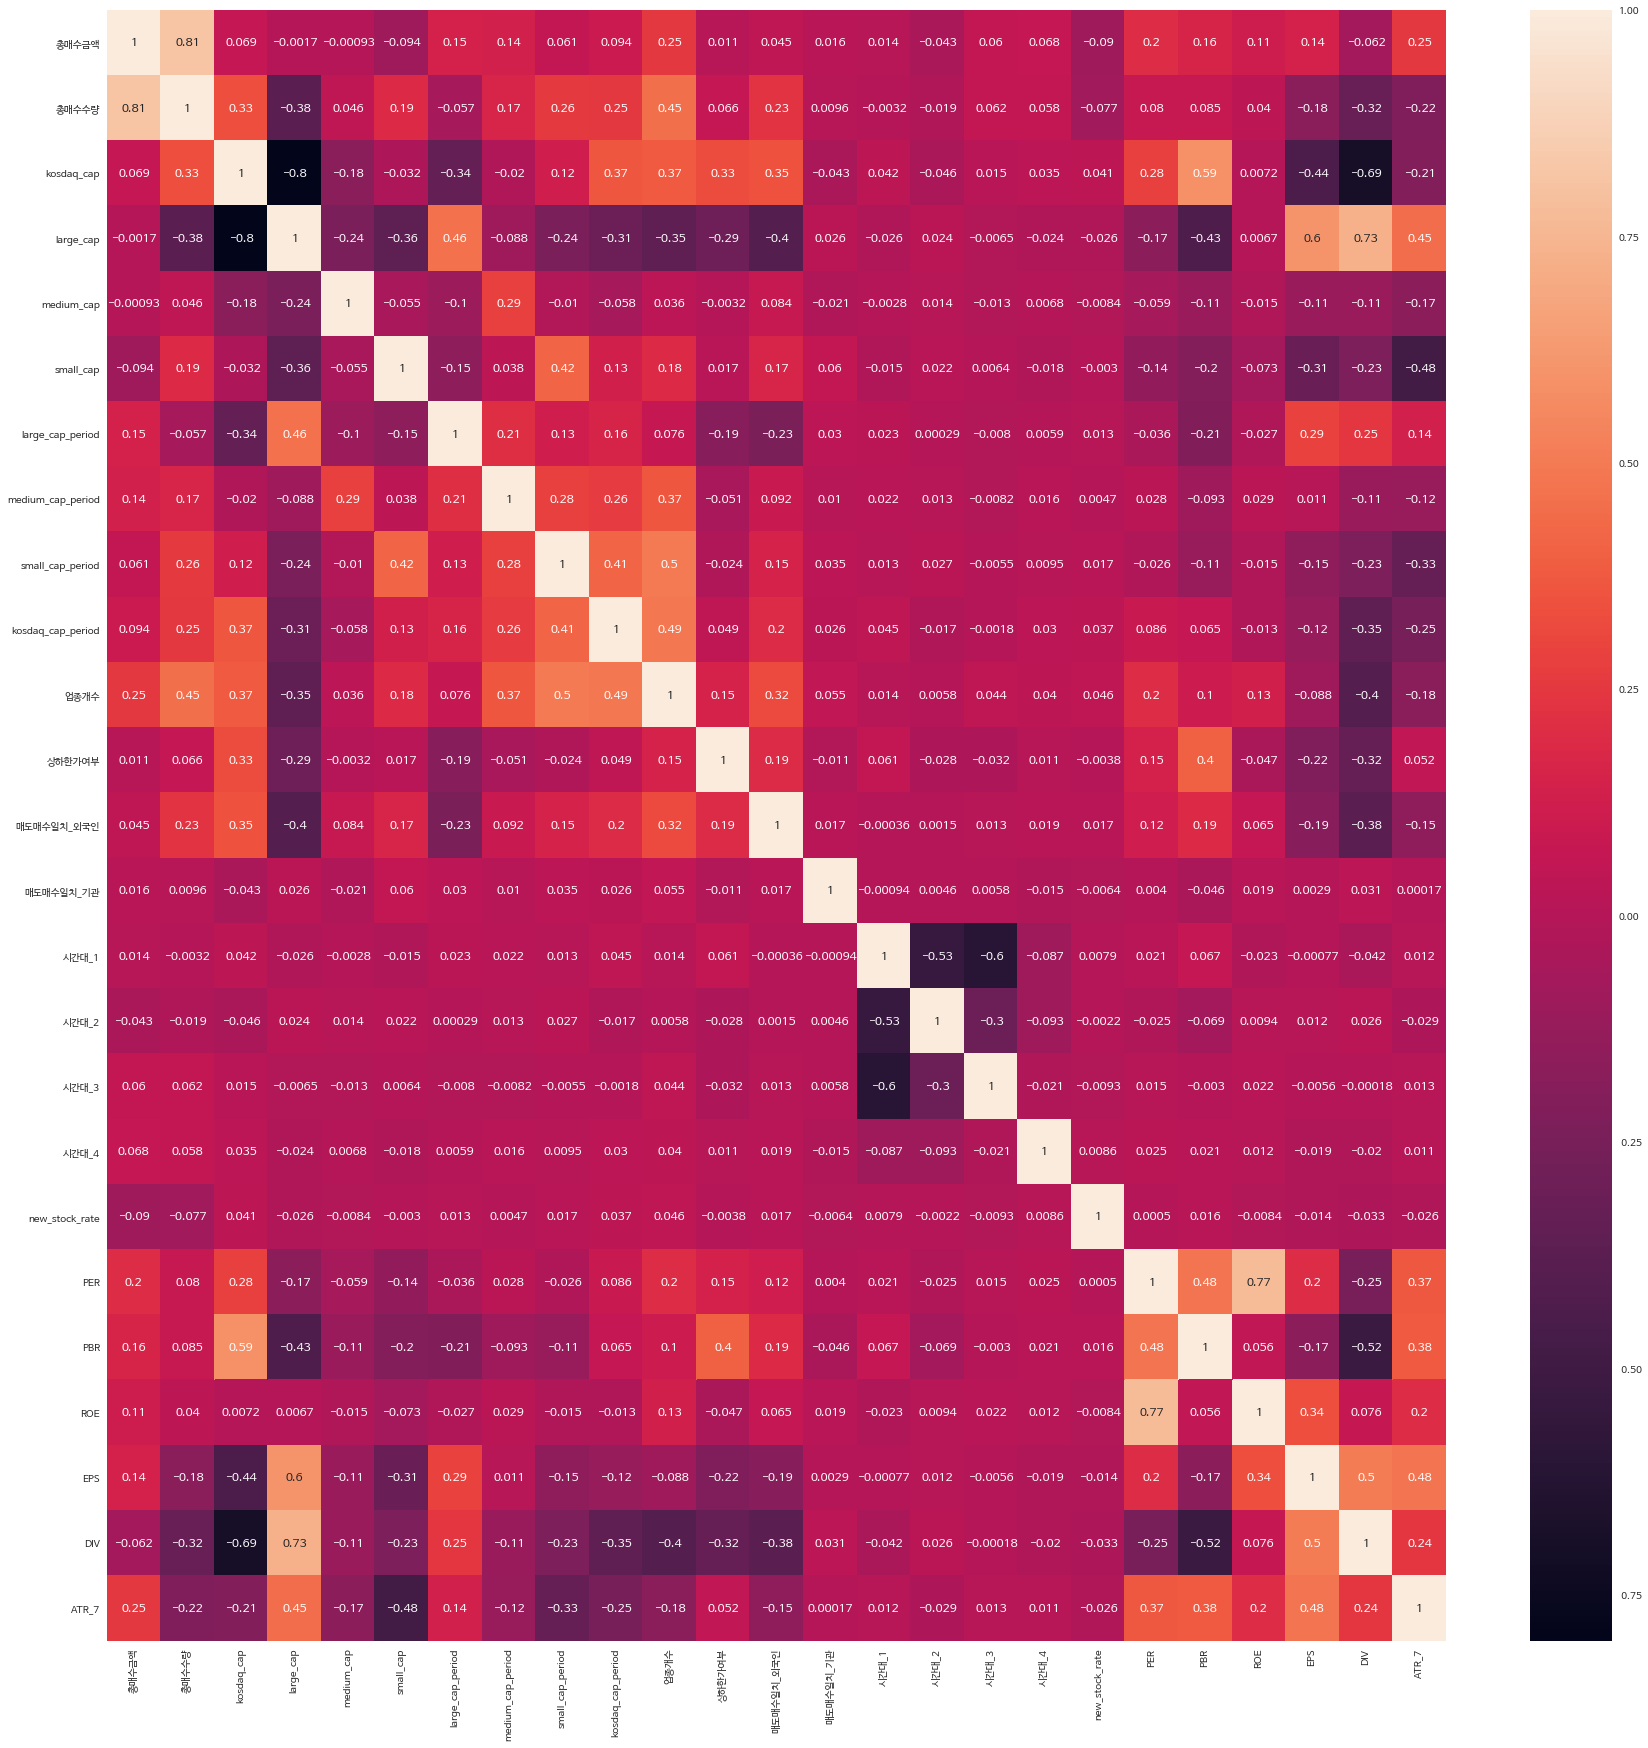

In [177]:
import warnings 
warnings.filterwarnings(action='ignore')
import seaborn as sns
plt.figure(figsize=(30,30))
plt.rc('font', family='NanumBarunGothic') 
sns.heatmap(customer_info_sc.corr(), annot= True, fmt ='0.2g')
# plt.show()
plt.savefig('상관분석.png')


## KMeans

In [178]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.savefig('KMeans_3.png')
    # plt.show()

In [179]:
kmeans = KMeans(n_clusters = 3, random_state=0)
kc = kmeans.fit_predict(customer_info_sc)

In [180]:
customer_info_kmeans = customer_info_sc.copy()
customer_info_kmeans['Cluster'] = kc
customer_info_kmeans

,총매수금액,총매수수량,kosdaq_cap,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,kosdaq_cap_period,업종개수,상하한가여부,매도매수일치_외국인,매도매수일치_기관,시간대_1,시간대_2,시간대_3,시간대_4,new_stock_rate,PER,PBR,ROE,EPS,DIV,ATR_7,Cluster
고객구분코드,,,,,,,,,,,,,,,,,,,,,,,,,,
A000973,14.341127,2.995732,0.000000,0.693147,0.000000,0.000000,1.871802,0.000000,0.000000,0.000000,1.098612,0.000000,0.223144,0.223144,0.559616,0.117783,0.117783,0.0,0.0,2.150404,0.532474,2.771242,9.483340,1.067348,8.831462,1
A00013780,16.708355,6.378426,0.491575,0.157592,0.177662,0.000000,0.000000,2.525729,0.000000,1.887070,1.386294,0.300105,0.300105,0.336472,0.336472,0.300105,0.223144,0.0,0.0,4.533822,1.986066,2.325473,5.686795,0.021330,8.452287,0
A0009975,12.183628,3.178054,0.000000,0.000000,0.693147,0.000000,0.000000,3.293365,0.000000,0.000000,0.693147,0.000000,0.095310,0.182322,0.470004,0.182322,0.182322,0.0,0.0,0.873801,0.528567,1.100366,8.705000,1.536114,6.247352,1
A00012551,16.842127,8.424859,0.611158,0.000000,0.000000,0.146208,0.000000,0.000000,0.000000,2.311635,2.772589,0.035091,0.381368,0.381368,0.278713,0.305382,0.278713,0.0,0.0,2.822543,0.806118,2.704537,6.129151,0.646334,6.643838,0
A000706,13.936038,7.494430,0.283328,0.281393,0.000000,0.298241,0.000000,0.000000,0.470004,3.401197,1.945910,0.000000,0.374693,0.435318,0.000000,0.167054,0.597837,0.0,0.0,1.087015,0.332050,0.940058,6.535961,0.219992,4.974314,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00011326,15.772883,8.539737,0.314062,0.484835,0.007093,0.000000,2.995732,0.000000,0.000000,2.564949,1.791759,0.087011,0.241162,0.374693,0.167054,0.435318,0.241162,0.0,0.0,2.475683,0.382300,2.757713,7.450516,0.811893,7.810589,0
A000162,18.361400,8.562931,0.600276,0.035834,0.131812,0.000000,2.833213,2.580217,0.000000,2.373681,1.945910,0.105361,0.393043,0.405465,0.380464,0.259511,0.215709,0.0,0.0,2.733134,1.553923,1.736996,5.131198,0.195344,8.110274,0
A0004156,13.178557,2.302585,0.072730,0.654698,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000,0.287682,0.154151,0.287682,0.405465,0.154151,0.0,0.0,2.707647,0.517092,2.871926,8.870794,1.575450,8.763003,1


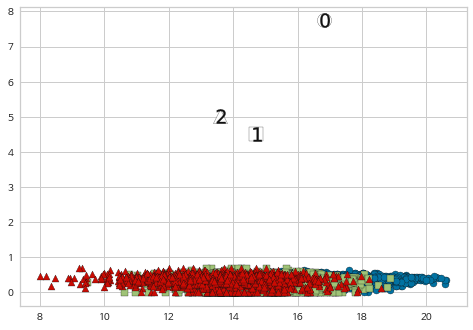

In [181]:
centers = kmeans.cluster_centers_
unique_labels = np.unique(kc)
markers= ['o','s','^','P','D','H','x']

for label in unique_labels:
  label_cluster = customer_info_kmeans.loc[customer_info_kmeans['Cluster'] ==label]
  center_x_y= centers[label]
  plt.scatter(x= label_cluster['총매수금액'],y= label_cluster['매도매수일치_외국인'], edgecolor = 'k',
               marker = markers[label])
  plt.scatter(x = center_x_y[0], y= center_x_y[1], s= 200, color= 'white',
               alpha= 0.9, edgecolor='k', marker = markers[label])
  plt.scatter(x = center_x_y[0], y= center_x_y[1], s= 200, color= 'k',
               edgecolor = 'k', marker = '$%d$' %label)
plt.show()


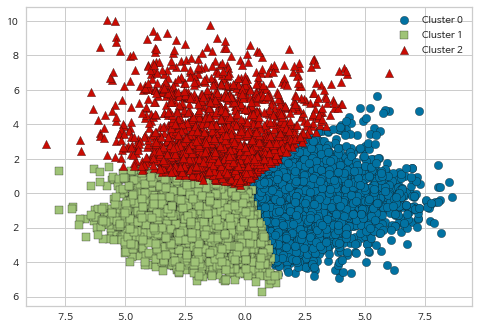

In [182]:
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(customer_info_sc)

pcaDF = customer_info_kmeans[['Cluster']]
pcaDF['ftr1'] = pca_transformed[:, 0]
pcaDF['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(kmeans, pcaDF, 'Cluster', iscenter=False)

yellowbrick
: https://www.kaggle.com/kautumn06/yellowbrick-clustering-evaluation-examples

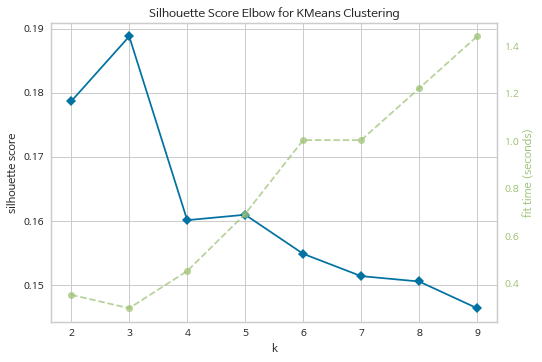

In [183]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='silhouette', timings=True, locate_elbow=False
)
visualizer.fit(customer_info_sc)
visualizer.poof()

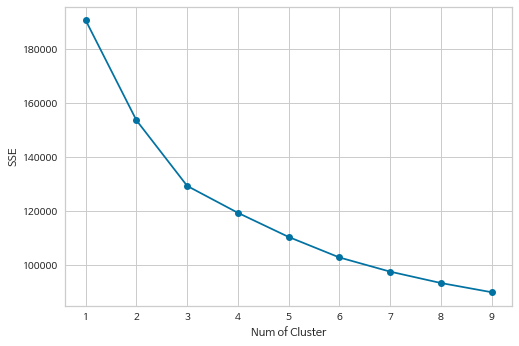

In [184]:
# Elbow
def elbow(X):
  sse = []
  for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

  plt.plot(range(1, 10), sse, marker='o')
  plt.xlabel('Num of Cluster')
  plt.ylabel('SSE')
  plt.show()

elbow(customer_info_sc)

In [185]:
def visualize_silhouette(cluster_lists, X_features): 
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

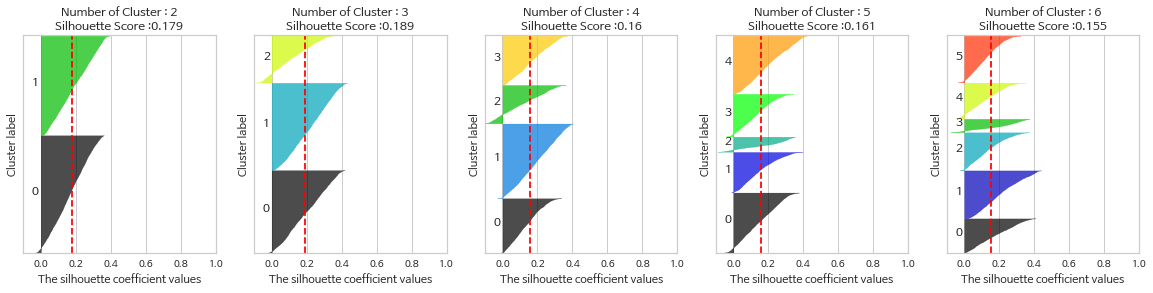

In [186]:
visualize_silhouette([2, 3, 4, 5, 6], customer_info_sc)

In [187]:
customer_info_kmeans

,총매수금액,총매수수량,kosdaq_cap,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,kosdaq_cap_period,업종개수,상하한가여부,매도매수일치_외국인,매도매수일치_기관,시간대_1,시간대_2,시간대_3,시간대_4,new_stock_rate,PER,PBR,ROE,EPS,DIV,ATR_7,Cluster
고객구분코드,,,,,,,,,,,,,,,,,,,,,,,,,,
A000973,14.341127,2.995732,0.000000,0.693147,0.000000,0.000000,1.871802,0.000000,0.000000,0.000000,1.098612,0.000000,0.223144,0.223144,0.559616,0.117783,0.117783,0.0,0.0,2.150404,0.532474,2.771242,9.483340,1.067348,8.831462,1
A00013780,16.708355,6.378426,0.491575,0.157592,0.177662,0.000000,0.000000,2.525729,0.000000,1.887070,1.386294,0.300105,0.300105,0.336472,0.336472,0.300105,0.223144,0.0,0.0,4.533822,1.986066,2.325473,5.686795,0.021330,8.452287,0
A0009975,12.183628,3.178054,0.000000,0.000000,0.693147,0.000000,0.000000,3.293365,0.000000,0.000000,0.693147,0.000000,0.095310,0.182322,0.470004,0.182322,0.182322,0.0,0.0,0.873801,0.528567,1.100366,8.705000,1.536114,6.247352,1
A00012551,16.842127,8.424859,0.611158,0.000000,0.000000,0.146208,0.000000,0.000000,0.000000,2.311635,2.772589,0.035091,0.381368,0.381368,0.278713,0.305382,0.278713,0.0,0.0,2.822543,0.806118,2.704537,6.129151,0.646334,6.643838,0
A000706,13.936038,7.494430,0.283328,0.281393,0.000000,0.298241,0.000000,0.000000,0.470004,3.401197,1.945910,0.000000,0.374693,0.435318,0.000000,0.167054,0.597837,0.0,0.0,1.087015,0.332050,0.940058,6.535961,0.219992,4.974314,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00011326,15.772883,8.539737,0.314062,0.484835,0.007093,0.000000,2.995732,0.000000,0.000000,2.564949,1.791759,0.087011,0.241162,0.374693,0.167054,0.435318,0.241162,0.0,0.0,2.475683,0.382300,2.757713,7.450516,0.811893,7.810589,0
A000162,18.361400,8.562931,0.600276,0.035834,0.131812,0.000000,2.833213,2.580217,0.000000,2.373681,1.945910,0.105361,0.393043,0.405465,0.380464,0.259511,0.215709,0.0,0.0,2.733134,1.553923,1.736996,5.131198,0.195344,8.110274,0
A0004156,13.178557,2.302585,0.072730,0.654698,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000,0.287682,0.154151,0.287682,0.405465,0.154151,0.0,0.0,2.707647,0.517092,2.871926,8.870794,1.575450,8.763003,1


## DT적용--> feature_importance

In [188]:
X = customer_info_kmeans.drop('Cluster', axis=1)
y = customer_info_kmeans['Cluster']

In [189]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [190]:
importance = dt.feature_importances_
importance

array([6.92192440e-02, 4.00955211e-01, 5.18321413e-03, 2.27252792e-02,
       1.16722629e-03, 4.36028745e-03, 1.31165686e-02, 1.27799762e-02,
       3.37189412e-02, 9.65470607e-03, 5.68085502e-03, 1.34522653e-03,
       3.94029939e-03, 2.36373400e-03, 1.67948180e-03, 3.82800787e-03,
       5.65533104e-03, 9.57043621e-04, 1.28034351e-04, 2.40465697e-02,
       5.14401555e-03, 6.39704675e-03, 3.29510670e-01, 5.95501153e-03,
       3.04880183e-02])

In [193]:
drop_columns= pd.DataFrame((zip(X.columns,importance))).sort_values(by=1, ascending =False).reset_index(drop =True).iloc[10:,0]

In [194]:
drop_columns

10               ROE
11               DIV
12              업종개수
13             시간대_3
14        kosdaq_cap
15               PBR
16         small_cap
17        매도매수일치_외국인
18             시간대_2
19         매도매수일치_기관
20             시간대_1
21            상하한가여부
22        medium_cap
23             시간대_4
24    new_stock_rate
Name: 0, dtype: object

##KMeans (컬럼제외)

In [195]:
kmeans = KMeans(n_clusters = 3, random_state=0)
kc = kmeans.fit_predict(customer_info_sc.drop(drop_columns,axis=1).copy())

In [196]:
customer_info_kmeans = customer_info_sc.drop(drop_columns,axis=1).copy()
customer_info_kmeans['Cluster'] = kc
customer_info_kmeans

,총매수금액,총매수수량,large_cap,large_cap_period,medium_cap_period,small_cap_period,kosdaq_cap_period,PER,EPS,ATR_7,Cluster
고객구분코드,,,,,,,,,,,
A000973,14.341127,2.995732,0.693147,1.871802,0.000000,0.000000,0.000000,2.150404,9.483340,8.831462,1
A00013780,16.708355,6.378426,0.157592,0.000000,2.525729,0.000000,1.887070,4.533822,5.686795,8.452287,2
A0009975,12.183628,3.178054,0.000000,0.000000,3.293365,0.000000,0.000000,0.873801,8.705000,6.247352,1
A00012551,16.842127,8.424859,0.000000,0.000000,0.000000,0.000000,2.311635,2.822543,6.129151,6.643838,2
A000706,13.936038,7.494430,0.281393,0.000000,0.000000,0.470004,3.401197,1.087015,6.535961,4.974314,0
...,...,...,...,...,...,...,...,...,...,...,...
A00011326,15.772883,8.539737,0.484835,2.995732,0.000000,0.000000,2.564949,2.475683,7.450516,7.810589,2
A000162,18.361400,8.562931,0.035834,2.833213,2.580217,0.000000,2.373681,2.733134,5.131198,8.110274,2
A0004156,13.178557,2.302585,0.654698,0.000000,0.000000,0.000000,0.693147,2.707647,8.870794,8.763003,1


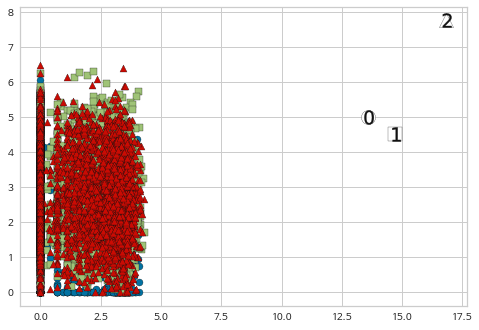

In [210]:
centers = kmeans.cluster_centers_
unique_labels = np.unique(kc)
markers= ['o','s','^','P','D','H','x']

for label in unique_labels:
  label_cluster = customer_info_kmeans.loc[customer_info_kmeans['Cluster'] ==label]
  center_x_y= centers[label]
  plt.scatter(x= label_cluster['large_cap_period'],y= label_cluster['PER'], edgecolor = 'k',
               marker = markers[label])
  plt.scatter(x = center_x_y[0], y= center_x_y[1], s= 200, color= 'white',
               alpha= 0.9, edgecolor='k', marker = markers[label])
  plt.scatter(x = center_x_y[0], y= center_x_y[1], s= 200, color= 'k',
               edgecolor = 'k', marker = '$%d$' %label)
plt.show()


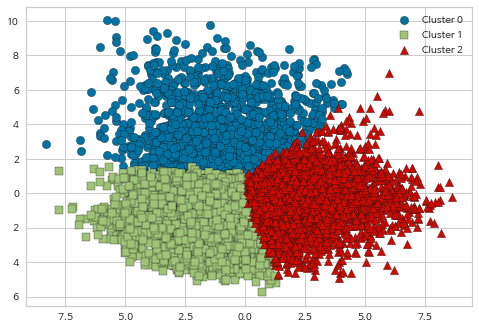

In [198]:
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(customer_info_sc)

pcaDF = customer_info_kmeans[['Cluster']]
pcaDF['ftr1'] = pca_transformed[:, 0]
pcaDF['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(kmeans, pcaDF, 'Cluster', iscenter=False)

yellowbrick
: https://www.kaggle.com/kautumn06/yellowbrick-clustering-evaluation-examples

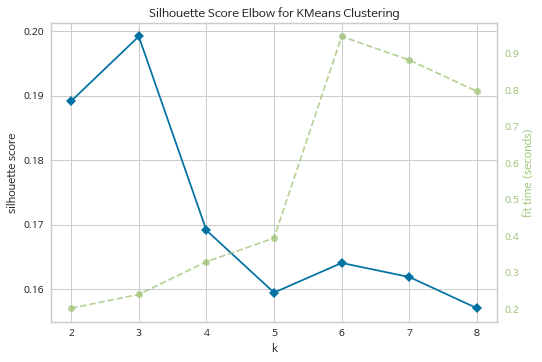

In [199]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,9), metric='silhouette', timings=True, locate_elbow=False
)
visualizer.fit(customer_info_sc.drop(drop_columns,axis=1).copy())
visualizer.poof()

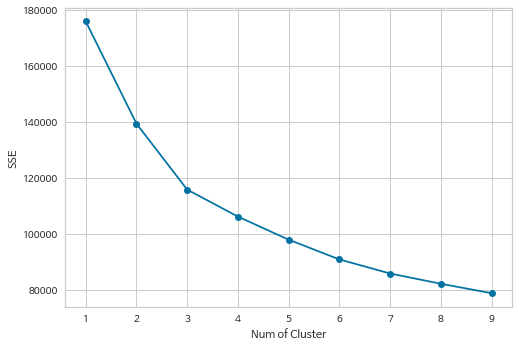

In [200]:
elbow(customer_info_sc.drop(drop_columns,axis=1).copy())

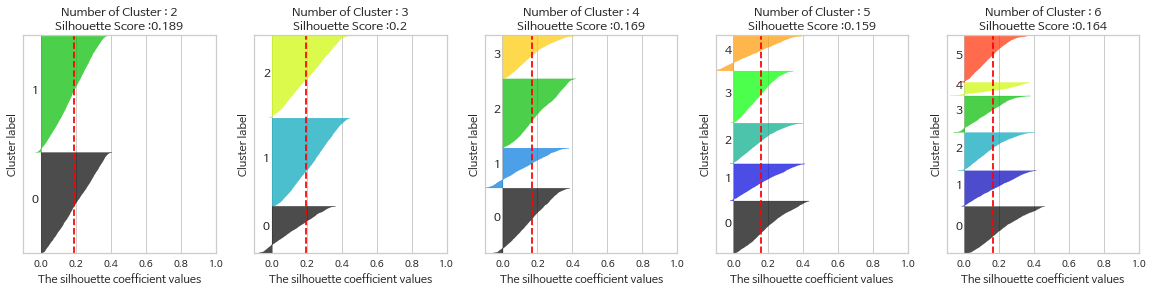

In [201]:
visualize_silhouette([2, 3, 4, 5, 6], customer_info_sc.drop(drop_columns,axis=1).copy())

## DBSCAN

In [207]:
dbscan = DBSCAN(eps=2, min_samples=2, metric='euclidean')
dbscan_labels = dbscan.fit_predict(customer_info_sc)

In [208]:
customer_info_dbscan = customer_info_sc.copy()
customer_info_dbscan['Cluster'] = dbscan_labels
customer_info_dbscan

,총매수금액,총매수수량,kosdaq_cap,large_cap,medium_cap,small_cap,large_cap_period,medium_cap_period,small_cap_period,kosdaq_cap_period,업종개수,상하한가여부,매도매수일치_외국인,매도매수일치_기관,시간대_1,시간대_2,시간대_3,시간대_4,new_stock_rate,PER,PBR,ROE,EPS,DIV,ATR_7,Cluster
고객구분코드,,,,,,,,,,,,,,,,,,,,,,,,,,
A000973,14.341127,2.995732,0.000000,0.693147,0.000000,0.000000,1.871802,0.000000,0.000000,0.000000,1.098612,0.000000,0.223144,0.223144,0.559616,0.117783,0.117783,0.0,0.0,2.150404,0.532474,2.771242,9.483340,1.067348,8.831462,0
A00013780,16.708355,6.378426,0.491575,0.157592,0.177662,0.000000,0.000000,2.525729,0.000000,1.887070,1.386294,0.300105,0.300105,0.336472,0.336472,0.300105,0.223144,0.0,0.0,4.533822,1.986066,2.325473,5.686795,0.021330,8.452287,0
A0009975,12.183628,3.178054,0.000000,0.000000,0.693147,0.000000,0.000000,3.293365,0.000000,0.000000,0.693147,0.000000,0.095310,0.182322,0.470004,0.182322,0.182322,0.0,0.0,0.873801,0.528567,1.100366,8.705000,1.536114,6.247352,0
A00012551,16.842127,8.424859,0.611158,0.000000,0.000000,0.146208,0.000000,0.000000,0.000000,2.311635,2.772589,0.035091,0.381368,0.381368,0.278713,0.305382,0.278713,0.0,0.0,2.822543,0.806118,2.704537,6.129151,0.646334,6.643838,0
A000706,13.936038,7.494430,0.283328,0.281393,0.000000,0.298241,0.000000,0.000000,0.470004,3.401197,1.945910,0.000000,0.374693,0.435318,0.000000,0.167054,0.597837,0.0,0.0,1.087015,0.332050,0.940058,6.535961,0.219992,4.974314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00011326,15.772883,8.539737,0.314062,0.484835,0.007093,0.000000,2.995732,0.000000,0.000000,2.564949,1.791759,0.087011,0.241162,0.374693,0.167054,0.435318,0.241162,0.0,0.0,2.475683,0.382300,2.757713,7.450516,0.811893,7.810589,0
A000162,18.361400,8.562931,0.600276,0.035834,0.131812,0.000000,2.833213,2.580217,0.000000,2.373681,1.945910,0.105361,0.393043,0.405465,0.380464,0.259511,0.215709,0.0,0.0,2.733134,1.553923,1.736996,5.131198,0.195344,8.110274,0
A0004156,13.178557,2.302585,0.072730,0.654698,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000,0.287682,0.154151,0.287682,0.405465,0.154151,0.0,0.0,2.707647,0.517092,2.871926,8.870794,1.575450,8.763003,0


In [209]:
customer_info_dbscan.Cluster.value_counts(sort= True)

 0      6548
-1       954
 1        90
 7        67
 53       21
        ... 
 54        2
 58        2
 66        2
 74        2
 105       2
Name: Cluster, Length: 107, dtype: int64

IndexError: ignored

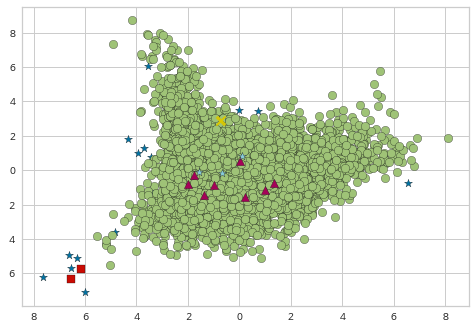

In [88]:
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(customer_info_sc)

# pcaDF = pd.DataFrame()
customer_info_dbscan['ftr1'] = pca_transformed[:, 0]
customer_info_dbscan['ftr2'] = pca_transformed[:, 1]

visualize_cluster_plot(dbscan, customer_info_dbscan, 'Cluster', iscenter=False)